<a href="https://colab.research.google.com/github/mrefugionv/S14----TIENDA-EN-L-NEA-_PRUEBA-AB-/blob/main/P14_PRUEBA_AB_TIENDA_LINEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Pruebas A/B
María del Refugio Noriega Vargas

## Descripción técnica

* Nombre de la prueba: recommender_system_test
* Grupos: А (control), B (nuevo embudo de pago)
* Fecha de lanzamiento: 2020-12-07
* Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
* Fecha de finalización: 2021-01-01
* Audiencia: 15% de los nuevos usuarios de la región de la UE
* Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
* Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el `evento product_page`), instancias de agregar artículos al carrito de compras (`product_cart`) y compras (`purchase`). En cada etapa del embudo `product_page` → `product_cart` → `purchase`, habrá al menos un 10% de aumento.
* Número previsto de participantes de la prueba: 6 000

## Preparación de los datos

### Importación de las librerías

In [ ]:
import pandas as pd            # Manejo de dataframes
import datetime as dt          # Manejo de fechas
import matplotlib.pyplot as plt  # Graficar
import numpy as np              # Matrices
import seaborn as sns              # Gráfico caja- bigotes
import scipy.stats as stats         # Métodos estadísticos

### Importación de los datos

Tenemos 4 datasets:
- `calendar` - El calendario de eventos de marketing para 2020.
- `new_users` -  Los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020.
- `events` - Los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021.
- `data` - Tabla con los datos de los participantes de la prueba.

In [ ]:
calendar = pd.read_csv('datasets/ab_project_marketing_events_us.csv')
new_users = pd.read_csv('datasets/final_ab_new_users_upd_us.csv')
events = pd.read_csv('datasets/final_ab_events_upd_us.csv')
data = pd.read_csv('datasets/final_ab_participants_upd_us.csv')

## Preprocesamiento de los datos


 ### Tipos de datos, formato de columnas, manejo de valores auscentes y duplicados

In [ ]:

def col_name_snakecase(data):
    """
    Función que toma un dataframe y
    transforma el nombre de sus columnas a snake_case
    """
    new_col_names =[]

    for old_name in data.columns:
        name_stripped = old_name.strip()
        name_lowered = name_stripped.lower()
        name_no_spaces = name_lowered.replace(' ','_')
        new_col_names.append(name_no_spaces)

    data.columns = new_col_names
    return(data)

#### DF Calendar

El dataframe `calendar` contiene el calendario de eventos de marketing, son 14 filas sin valores auscentes ni duplicados. Los campos describen:
- `name`: el nombre del evento de marketing, tipo de dato objeto.
-  `regions` : regiones donde se llevara a cabo la campaña, tipo de dato objeto.
-  `start_dt` : fecha de inicio de la campaña , tipo de dato datetime.
-  `finist_dt` : fecha de finalización de la campaña, tipo de dato datetime.


In [ ]:
display(calendar.head())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [ ]:
#Corrección de tipos de datos
calendar['start_dt']= calendar['start_dt'].astype('string')
calendar['finish_dt']= calendar['finish_dt'].astype('string')
calendar['start_dt'] = calendar['start_dt'].map( lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
calendar['finish_dt'] = calendar['finish_dt'].map( lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
print(calendar.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes
None


In [ ]:
##¿Hay filas duplicadas?
calendar[calendar.duplicated(keep=False)]

,name,regions,start_dt,finish_dt


#### DF New Users

El dataframe `new_users` contiene todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020, son 58703 filas sin valores auscentes ni duplicados. Los campos describen:
- `user_id`: identificador del usuario, tipo de dato objeto.
-  `fist_date` : fecha de inscripción , tipo de dato datetime.
-  `region` : región donde se llevara a cabo el registro, tipo de dato objeto.
-  `device` : tipo de dispositivo utilizado para la inscripción, tipo de dato object.

Se obtiene el dataframe de los usuraios nuevo solo de EU, ya que a ellos es a quienes se le aplicó la prueba. "Audiencia: 15% de los nuevos usuarios de la región de la UE"

In [ ]:
display(new_users.head())

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [ ]:
#Correción de tipos de datos
new_users['first_date']=new_users['first_date'].astype('string')
new_users['first_date']=new_users['first_date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
print(new_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
None


In [ ]:
# ¿Hay filas duplicadas?
new_users[new_users.duplicated(keep=False)]

,user_id,first_date,region,device


In [ ]:
new_users_eu = new_users[new_users['region'] == 'EU']
print(new_users_eu.info())

<class 'pandas.core.frame.DataFrame'>
Index: 43396 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     43396 non-null  object        
 1   first_date  43396 non-null  datetime64[ns]
 2   region      43396 non-null  object        
 3   device      43396 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.7+ MB
None


#### DF Events

El dataframe `events` contiene todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021, son 423761 entrada sin valores duplicados. Los campos describen:
- `user_id`: identificador del usuario, tipo de dato objeto.
-  `event_dt` : fecha y hora del evento , tipo de dato datetime.
-  `event_name` : nombre del tio de event, tipo de dato objeto.
-  `details` : datos adicionales sobre el evento, tipo de dato flotante.

En cuanto a valores ausentes, en la columna `details` solo hay 60314 campos completos. Eso se debe a que representan los detalles del tipo de evento registrado; hay cuatro tipos de evento : `purchase` ,`product_cart`, `product_page`,`login`; y el único de que se tienen detalles es `purchase`, con el monto de la compra (USD). Por lo que se decide rellenaar esos valores aucentes con un valor mucho mayor a los valores contenidoes en esa columna, para que se puedan diferenciar al procesarlos.

In [ ]:
display(events.sample(n=5, random_state=0))

,user_id,event_dt,event_name,details
360553,5550F454694429EF,2020-12-21 04:37:36,login,NaN
39456,B44A5B768770CE72,2020-12-21 12:55:18,purchase,4.99
219407,97A3B2B75AE4B149,2020-12-23 12:54:53,product_page,NaN
125513,0434D0498B5592FB,2020-12-08 11:31:26,product_page,NaN
347284,45E148F9010A66D3,2020-12-20 07:34:40,login,NaN


In [ ]:
# Corrección de tipos de datos
events['event_dt']=events['event_dt'].astype('string')
events['event_dt'] = events['event_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
display(events.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


None

In [ ]:
#¿Hay filas duplicadas?
events[events.duplicated(keep=False)]

,user_id,event_dt,event_name,details


In [ ]:
#Exploración de motivos por las que hay valores ausentes en 'details'
print(f'Categorías de eventos:\n',events['event_name'].unique())
print()
print(f"Cantidad de evento 'purchase':\n",events[events['event_name'] == 'purchase'].count())
print()
print(f'Valores únicos en details:\n',events['details'].unique())
print(f'Valor mínimo en details:\n',events['details'].min())
print(f'Valor máximo en details:\n',events['details'].max())

Categorías de eventos:
 ['purchase' 'product_cart' 'product_page' 'login']

Cantidad de evento 'purchase':
 user_id       60314
event_dt      60314
event_name    60314
details       60314
dtype: int64

Valores únicos en details:
 [ 99.99   9.99   4.99 499.99    nan]
Valor mínimo en details:
 4.99
Valor máximo en details:
 499.99


In [ ]:
#Rellenamos valores ausentes

events['details'].fillna(1500 , inplace=True)

print(events.info())
print()
print(f'Valores únicos en event_name:\n',events['event_name'].unique())
print(f'Valores únicos en details:\n',events['details'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     423761 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB
None

Valores únicos en event_name:
 ['purchase' 'product_cart' 'product_page' 'login']
Valores únicos en details:
 [  99.99    9.99    4.99  499.99 1500.  ]


C:\Users\cucum\AppData\Local\Temp\ipykernel_3768\232146942.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  events['details'].fillna(1500 , inplace=True)


#### DF Data


El dataframe `data` contiene los datos de los participantes de la prueba, son 14525 filas sin valores auscentes ni duplicados. Los campos describen:
- `user_id`: identificador del usuario, tipo de dato objeto.
-  `ab_test` : nombre de la prueba , tipo de dato objeto, valores pueden ser: 'recommender_system_test' o 'interface_eu_test'.
-  `group` : el grupo de prueba al que pertenecía el usuario, tipo de dato objeto: A/B.

Como la prueba A/B que se estudiara es 'recommender_system_test', se filtra el data frame y solo obtenemos los 3675 registros de esta prueba, menos de los 6000 participantes de la prueba que se esperaba. 2747 usuarios son grupo A y 928 son grupo B.

In [ ]:
display(data.head())

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None


In [ ]:
#¿Hay datos duplicados?
data[data.duplicated(keep=False)]

,user_id,group,ab_test


In [ ]:
print(f"Valores únicos para 'ab_test':\n", data['ab_test'].unique())
print()
print(f"Valores únicos para 'group':\n", data['group'].unique())

Valores únicos para 'ab_test':
 ['recommender_system_test' 'interface_eu_test']

Valores únicos para 'group':
 ['A' 'B']


In [ ]:
# Solo se revisaran los datos de la prueba 'recommender_system_test'
data = data[data['ab_test']=='recommender_system_test']


print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3675 entries, 0 to 3674
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  3675 non-null   object
 1   group    3675 non-null   object
 2   ab_test  3675 non-null   object
dtypes: object(3)
memory usage: 114.8+ KB
None


## Análisis Exploratorio de Datos

### ¿Hay usuarios que están presentes en ambas muestras?

No hay usuario repetidos en los grupos

In [ ]:
# Dataframes de grupo A y B
data_A = data[data['group']=='A']
data_B = data[data['group']=='B']
# Unimos en user_id para verificar que no este el mismo usuario en ambos grupos
data_both = data_A.merge(data_B, how='inner', on='user_id',suffixes=('_a', '_b'))
print(data_both.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    0 non-null      object
 1   group_a    0 non-null      object
 2   ab_test_a  0 non-null      object
 3   group_b    0 non-null      object
 4   ab_test_b  0 non-null      object
dtypes: object(5)
memory usage: 132.0+ bytes
None


### ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

- Para el grupo **A** tenemos **2727 usuarios** con un total de **18,627 eventos**.
- Para el grupo **B** tenemos **928 usuarios** con un total de **5,282 eventos**.

El grupo A representa un 74.61% de los usuarios en prueba y el B el 25.38%
Para el grupo A hay en promedio 6.8 eventos registrados por usuario y en el grupo B son 5.69 eventos por usuario en promedio.

In [ ]:
# Obtención de eventos para usuarios de grupo A y B
events_A = events.merge(data_A, how='right', on='user_id',suffixes=('_events', '_a'))
new_users_eu_A = new_users_eu.merge(data_A, how='right', on='user_id',suffixes=('_new_users', '_a'))
df_A= events_A.merge(new_users_eu_A, how='right', on='user_id',suffixes=('_events', '_new_users'))
#display(events_A.info()) #18627 eventos
#display(new_users_eu_A.info()) #2727 usuarios
display(df_A.head())
#display(df_A.info()) #18627

events_B = events.merge(data_B, how='right', on='user_id',suffixes=('_events', '_b'))
new_users_eu_B = new_users_eu.merge(data_B, how='right', on='user_id',suffixes=('_new_users', '_b'))
df_B= events_B.merge(new_users_eu_B, how='right', on='user_id',suffixes=('_events', '_new_users'))
#display(events_B.info()) #5282 eventos
#display(new_users_eu_B.info()) #928 usuarios
display(df_B.head())
#display(df_B.info()) #5282

,user_id,event_dt,event_name,details,group_events,ab_test_events,first_date,region,device,group_new_users,ab_test_new_users
0,D1ABA3E2887B6A73,2020-12-07 14:43:27,purchase,99.99,A,recommender_system_test,2020-12-07,EU,PC,A,recommender_system_test
1,D1ABA3E2887B6A73,2020-12-07 14:43:29,product_cart,1500.00,A,recommender_system_test,2020-12-07,EU,PC,A,recommender_system_test
2,D1ABA3E2887B6A73,2020-12-07 14:43:27,product_page,1500.00,A,recommender_system_test,2020-12-07,EU,PC,A,recommender_system_test
3,D1ABA3E2887B6A73,2020-12-07 14:43:27,login,1500.00,A,recommender_system_test,2020-12-07,EU,PC,A,recommender_system_test
4,A7A3664BD6242119,2020-12-20 15:46:06,product_page,1500.00,A,recommender_system_test,2020-12-20,EU,iPhone,A,recommender_system_test


,user_id,event_dt,event_name,details,group_events,ab_test_events,first_date,region,device,group_new_users,ab_test_new_users
0,CD74C3D22FFC09C2,2020-12-21 14:10:54,product_page,1500.0,B,recommender_system_test,2020-12-21,EU,Android,B,recommender_system_test
1,CD74C3D22FFC09C2,2020-12-22 11:22:05,product_page,1500.0,B,recommender_system_test,2020-12-21,EU,Android,B,recommender_system_test
2,CD74C3D22FFC09C2,2020-12-28 18:43:12,product_page,1500.0,B,recommender_system_test,2020-12-21,EU,Android,B,recommender_system_test
3,CD74C3D22FFC09C2,2020-12-21 14:10:51,login,1500.0,B,recommender_system_test,2020-12-21,EU,Android,B,recommender_system_test
4,CD74C3D22FFC09C2,2020-12-22 11:22:03,login,1500.0,B,recommender_system_test,2020-12-21,EU,Android,B,recommender_system_test


### Embudos de conversión

Observamos algunos cambios para el embudo de conversión del grupo A y del grupo B:

| Etapa | Cantidad A | Porcentaje A| Cantidad B | Porcentaje B|
|-----|-----|----|---|--|
|Login | 2747 | 100 | 927 | 100 |
|Product Page | 1012 | 36.84 | 284| 30.64|
|Product Cart | 54 | 5.33 | 23 | 8.09|
| Purchase | 0 | 0 | 1 | 4.34 |

Notas:
* Cantidad: se refiere a las cantidad de usurios del respectivo grupo.
* Porcentaje : es el porcentaje respecto a la etapa anterior del mismo grupo.

In [ ]:
def funnel(df, group):

    # Primer evento de cada clase por usuario
    funnel = df.pivot_table(
        index='user_id',
        columns='event_name',
        values='event_dt',
        aggfunc='min')

    #Solo los eventos que sucedieron en orden
    step_1 = ~funnel['login'].isna()
    step_2 = step_1 & (funnel['product_page'] > funnel['login'])
    step_3 = step_2 & (funnel['product_cart'] > funnel['product_page'])
    step_4 = step_3 & (funnel['purchase'] > funnel['product_cart'])

    #Cantidad de cada uno de los eventos
    n_login = funnel[step_1].shape[0]
    n_product_page= funnel[step_2].shape[0]
    n_product_cart = funnel[step_3].shape[0]
    n_purchase = funnel[step_4].shape[0]


    #Graficar porcentajes
    funnel_plot= {
        'Stage': ['Login', 'Product Page', 'Product Cart', 'Purchase'],
        'Quantity': [n_login,
                     n_product_page,
                     n_product_cart,
                     n_purchase],
        'Proportion': [100,
                     (n_product_page /n_login)*100,
                     (n_product_cart/n_product_page)*100,
                     (n_purchase/n_product_cart)*100]
    }
    funnel_plot_df = pd.DataFrame(funnel_plot)
    plt.style.use("dark_background")
    sns.barplot(x='Stage', y='Proportion', data=funnel_plot_df)
    plt.xlabel('Stage')
    plt.ylabel('Proportion')
    plt.title(f'Proportion by Stage {group}')
    plt.show()
    return(funnel_plot_df)

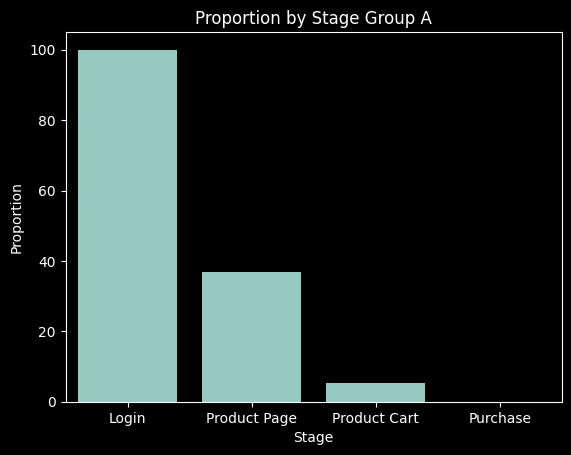

'Embudo A:\n'

,Stage,Quantity,Proportion
0,Login,2747,100.000000
1,Product Page,1012,36.840189
2,Product Cart,54,5.335968
3,Purchase,0,0.000000


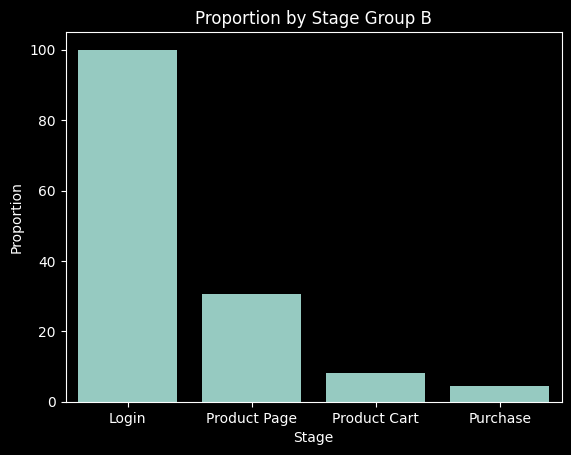

'Embudo B:\n'

,Stage,Quantity,Proportion
0,Login,927,100.000000
1,Product Page,284,30.636462
2,Product Cart,23,8.098592
3,Purchase,1,4.347826


In [ ]:
funnel_A = funnel(df_A,'Group A')
display(f"Embudo A:\n",funnel_A)
funnel_B = funnel(df_B,'Group B')
display(f"Embudo B:\n",funnel_B)

#print(df_A[df_A['event_name']=='purchase'].count()) # 2545
#print(df_B[df_B['event_name']=='purchase'].count()) #655

### ¿Cómo se distribuye el número de eventos entre los días?

Se obtuvieron las gráficas de comportamiento de cada una de las etapas (la cantidad de usuarios que realizo esa acción) a lo largo de los días  y también se obtuvo este mismo parámetro acumulativo para evitar el 'peeking' problem.

Observamos como entre los días 13 y el 25 de diciembre del 2025, Tanto grupo A como grupo B, tienen más entradas  dado que son las fechas de la estrategia de marketing 'Christmas&New Year Promo'	(3-25 dic). Los primero días (del 3 al 13) va aumentando los usuarios gradualmente, probablemente por el tiempo que tarda la difusión de la promoción.

La gráficas acumulativas nos permiten apreciar que para ambos grupos cada una de las acciones tienden a aumentar a lo largo del tiempo, probablemente por las fechas navideñas. Además se observa como la diferencia de usuarios que pasan de 'product_page' a 'product_cart', es mucho menor a entre los grups A y B ; lo que indica una perdida de usurios en ese paso mucho mayor  para el grupo A que para el B.


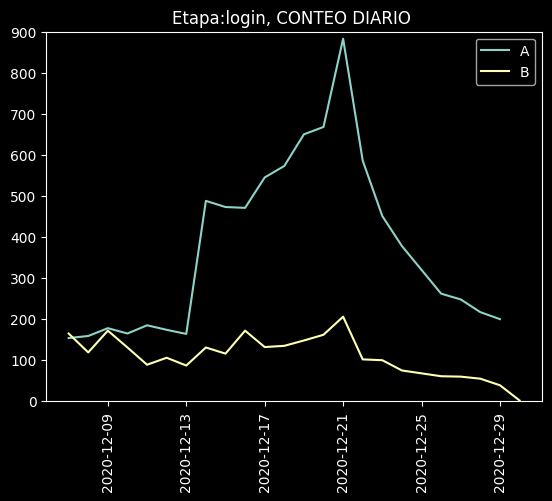

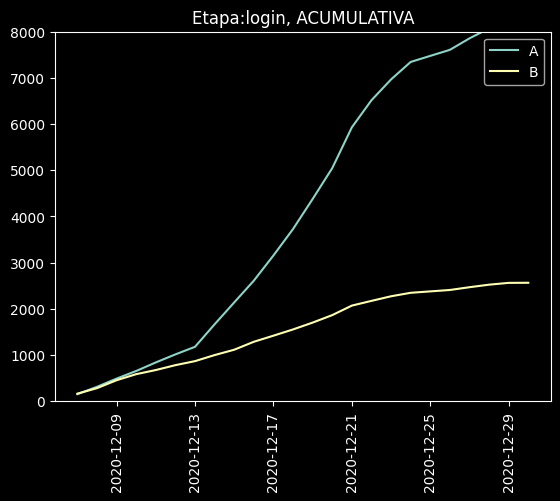

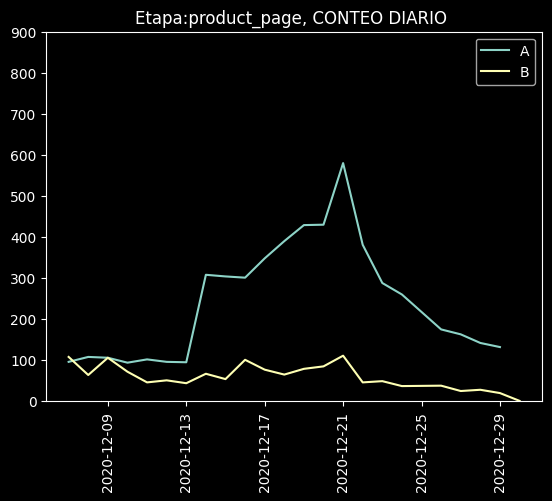

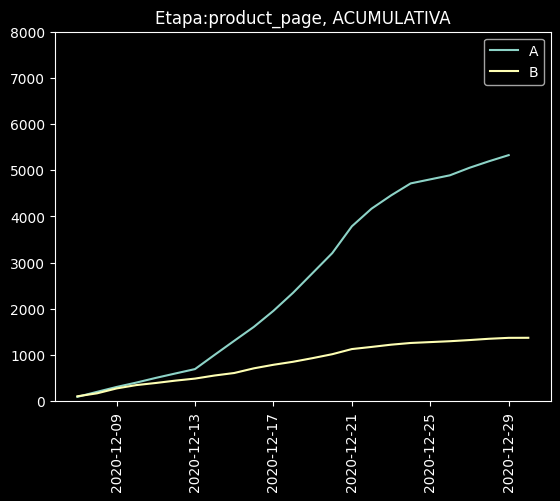

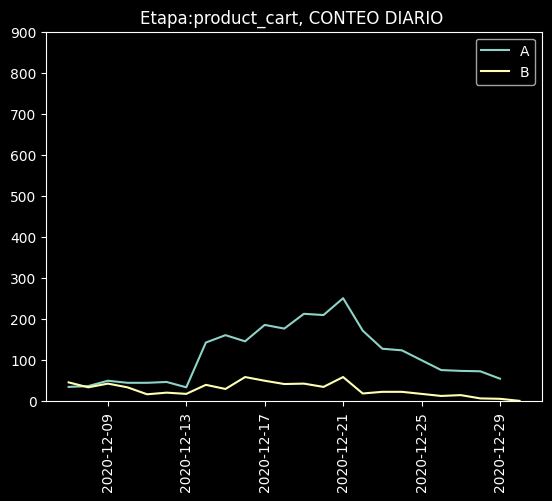

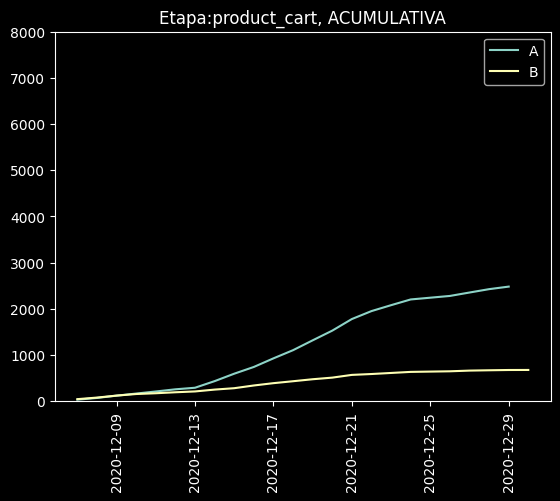

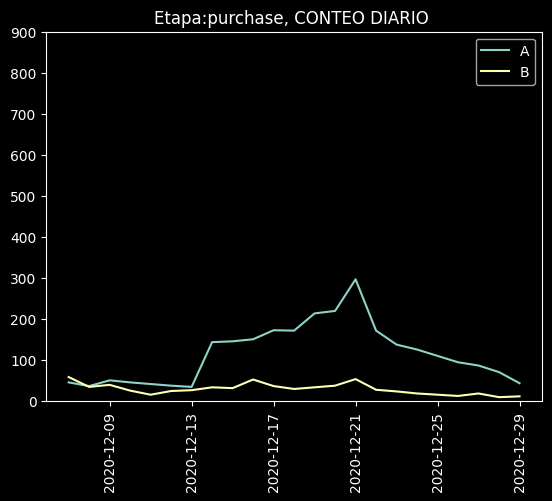

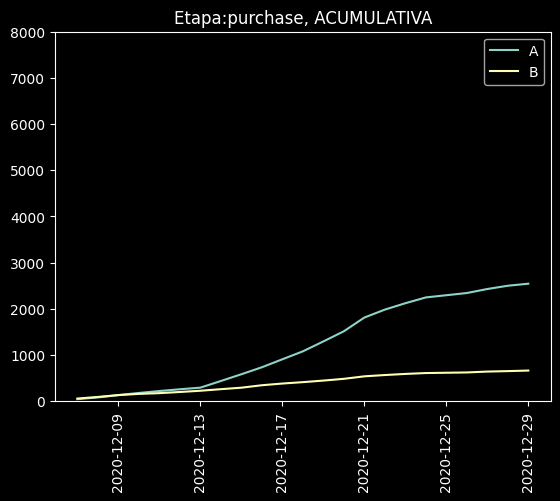

In [ ]:
events_df = pd.concat([events_A,events_B])
#Solo tomar en cuenta la fecha, quitar la hora
events_df['event_dt'] = events_df['event_dt'].dt.date

def acummulative_step(df,step):
    df_filtered = df[df['event_name']== step]

    df_A= df_filtered[df_filtered['group']=='A']
    df_B= df_filtered[df_filtered['group']=='B']

    df_A_grouped = df_A.groupby('event_dt').agg({'user_id':'count'}).reset_index()
    df_B_grouped = df_B.groupby('event_dt').agg({'user_id':'count'}).reset_index()

    plt.plot(df_A_grouped ['event_dt'], df_A_grouped ['user_id'], label='A')
    plt.plot(df_B_grouped['event_dt'], df_B_grouped['user_id'], label='B')
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylim((0,900))
    plt.title(f'Etapa:{step}, CONTEO DIARIO ')
    plt.show()

    # Parametro acumulativo
    df_date_grouped = df[['event_dt','group']].drop_duplicates()
    df_acumm= df_date_grouped.apply(lambda x: df_filtered[np.logical_and(df_filtered ['event_dt'] <= x['event_dt'], df_filtered ['group'] == x['group'])]
        .agg({'event_dt' : 'max', 'group' : 'max', 'user_id' : 'count'}), axis=1).sort_values(by=['event_dt','group'])
    df_acumm_A = df_acumm[df_acumm['group']=='A']
    df_acumm_B = df_acumm[df_acumm['group']=='B']
    plt.plot( df_acumm_A ['event_dt'],  df_acumm_A ['user_id'], label='A')
    plt.plot(df_acumm_B['event_dt'], df_acumm_B['user_id'], label='B')
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylim((0,8000))
    plt.title(f'Etapa:{step}, ACUMULATIVA')
    plt.show()
    return()



steps = ['login','product_page', 'product_cart','purchase']
for step in steps:
    acummulative_step(events_df,step)

### ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

Las prueba sobre "probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado" se realizo durante la temporada de la "Promoción Navideña" de la tienda. Lo cual puede afectar el confiar si lo que realmente funcionó fue la prueba lanzada o las temporadas navideñas.



## PRUEBA A/B


In [ ]:
#Tablas pivote con fecha, tipo de evento y conteo de usuarios

events_A['event_dt'] = events_A['event_dt'].dt.date
events_B['event_dt'] = events_B['event_dt'].dt.date

events_A_agg = events_A.groupby(['event_dt','event_name']).agg({'user_id':'count'}).reset_index()
events_A_pivot = events_A_agg.pivot(index='event_dt',columns='event_name',values='user_id')
events_B_agg = events_B.groupby(['event_dt','event_name']).agg({'user_id':'count'}).reset_index()
events_B_pivot = events_B_agg.pivot(index='event_dt',columns='event_name',values='user_id')

display(events_A_pivot.head())
display(events_B_pivot.head())

event_name,login,product_cart,product_page,purchase
event_dt,,,,
2020-12-07,154,35,96,46
2020-12-08,159,37,108,37
2020-12-09,178,50,106,51
2020-12-10,165,45,94,46
2020-12-11,185,45,102,42


event_name,login,product_cart,product_page,purchase
event_dt,,,,
2020-12-07,165.0,46.0,108.0,59.0
2020-12-08,119.0,34.0,64.0,35.0
2020-12-09,172.0,43.0,106.0,40.0
2020-12-10,131.0,34.0,72.0,26.0
2020-12-11,89.0,17.0,46.0,16.0


###  Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones.


H0: En cada etapa del embudo product_page → product_cart → purchase, habrá un aumento igual o mayor a un 10% de conversión.

H1: En cada etapa del embudo product_page → product_cart → purchase, habrá aumento menor al 10% de conversión.

Es una prueba de una cola.

In [ ]:
from statsmodels.stats.weightstats import ztest

def prueba_Z_una_cola(df_A, df_B, step1, step2):
    """
    1. Funcion toma los df de A y B ,
    2. calcula la tasa de conversión entre 'step1' y 'step2'
    3. Calcula el valo con el cual vamos a comparar :
    el 110% del valor medio de la tasa de conversión del grupo a
    4. Se hace la prueba Z test, prueba estadistica entre
    dataset (tasa de conversión grupo B) y valor (el calculado en el punto 3)
    5. Se hace una prueba de 1 cola.
    """
    alpha = 0.05

    df_A['tasa_conversion']= df_A[step2] /df_A[step1]
    df_B['tasa_conversion']= df_B[step2] /df_B[step1]

    value = (df_A['tasa_conversion'].mean())*1.1

    # Prueba Z compara datos grupo B con un valor
    # se utiliza el 110% del valor medio de grupo A ,
    # ya que debemos comprobar si aumento un 10% la tasa de conversión
    z, p_value  = ztest( df_B['tasa_conversion'], value= value)

    print(f"Prueba con tasa de conversión entre {step1} y {step2}")
    print(f'p_value={p_value}')
    if (p_value / 2 < alpha) and (df_B['tasa_conversion'].mean() > ((df_A['tasa_conversion'].mean())*1.1)):
        print('Rechazamos la hipotesis nula:.')
    else:
        print('No rechazamos la hipotesis nula: .')

    return()

prueba_Z_una_cola(events_A_pivot, events_B_pivot,'product_page','product_cart')
prueba_Z_una_cola(events_A_pivot, events_B_pivot,'product_cart','purchase')

Prueba con tasa de conversión entre product_page y product_cart
p_value=0.9839479997998055
No rechazamos la hipotesis nula: .
Prueba con tasa de conversión entre product_cart y purchase
p_value=nan
No rechazamos la hipotesis nula: .


()

### CONCLUSIONES

De acuerdo a lo que se pudo revisar en el Análisis exploratorio de los datos y los resultados estadísticos de la prueba A/B se puede concluir:
* Los resultados de la prueba pudieron verse afectados por la alsa en las ventas de la temporada de Navidad.
* El número de participantes previsto en la prueba era de 6000, mientras que solo se registraron 3675.
* No se obtuvo el resultado deseado, de un aumento del 10% en cada etapa del embudo : `product_page` → `product_cart` → `purchase`
* Sin embargo, sí hay una aumento en las proporciones de conversión en cada etapa del grupo B con respecto al A:
  * `product_page` → `product_cart`, grupo A cae 31.1% mientras que B 22.55%
  * `product_cart` → `purchase`, grupo A cae 5.33% mientras B 3.75%

Aunque para validar esta última observación se debe tomar en cuenta que en grupo A hay 2545 registradas , y en B hay únicamente 655. Sin embargo al hacer los embudos, tomando en cuenta el orden secuencial de los pasos, para A quedan 0 y para B 1.